In [9]:
import numpy as np
import os
import math
import matplotlib.pyplot as plt


This is if running ipynb in Colab

In [10]:
from google.colab import drive
drive.mount('/content/drive/')

os.chdir("/content/drive/MyDrive/ECE5242/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Gather orange cone masks from each labeled file and append them to one big matrix. However having a big matrix will cause problems later on when creating the Covariant Matrix which is one of the parameters used within the Multivariate Gaussian distribution model. Plot this matrix on a scatter plot

In [11]:
folder = 'Data/Labeled'
cone_roi_pixels = np.loadtxt(os.path.join(folder, os.listdir(folder)[0]))
#for index in range(1, len(os.listdir(folder))):
for index in range(1, 2):
    pixels_to_concat = np.loadtxt(os.path.join(folder, os.listdir(folder)[index]))
    cone_roi_pixels = np.concatenate((cone_roi_pixels, pixels_to_concat))

print(np.shape(cone_roi_pixels))

(4671, 3)


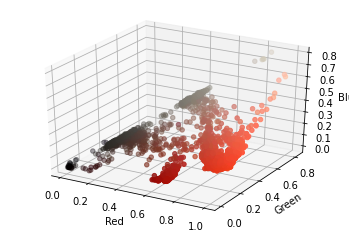

In [12]:
# Plot region of interest points onto scatter plot
fig = plt.figure()
scatter_plot = fig.add_subplot(projection='3d')
red_axis = cone_roi_pixels[:, 0]
green_axis = cone_roi_pixels[:, 1]
blue_axis = cone_roi_pixels[:, 2]
scatter_plot.scatter(red_axis, green_axis, blue_axis, c=cone_roi_pixels)
scatter_plot.set_xlabel('Red')
scatter_plot.set_ylabel('Green')
scatter_plot.set_zlabel('Blue')
plt.show()

Once you have that you want to calculate the average orange color value(aka mean), covariance(Use this instead of variance since working with multi-dimensions), and standard deviation of this region of interest. This information can be modeled as a bell curve or otherwise known as a Multivariate Gaussian Distribution(Multivariate because dealing with RGB).

The mean tells us where the center of the distribution is and the variance tells us the spread of the data in the distribution.

In [32]:
# RGB Mean
# orange_cone_rgb_mean = cone_roi_pixels.mean(0) Fast numpy method
orange_cone_rgb_mean = np.zeros(3)
for i in range(len(cone_roi_pixels)):
    orange_cone_rgb_mean[0] += cone_roi_pixels[i][0]
    orange_cone_rgb_mean[1] += cone_roi_pixels[i][1]
    orange_cone_rgb_mean[2] += cone_roi_pixels[i][2]
orange_cone_rgb_mean /= len(cone_roi_pixels)
orange_cone_rgb_mean = np.atleast_2d(orange_cone_rgb_mean).T

# RGB Covariance 
orange_cone_rgb_covariance = np.cov(cone_roi_pixels.T) # Fast numpy method
print(orange_cone_rgb_covariance)
# orange_cone_rgb_covariance = np.zeros(3)
# for i in range(len(cone_roi_pixels)):
#     orange_cone_rgb_covariance[0] += (cone_roi_pixels[i][0] - orange_cone_rgb_mean[0]) * np.transpose((cone_roi_pixels[i][0] - orange_cone_rgb_mean[0]))
#     orange_cone_rgb_covariance[1] += (cone_roi_pixels[i][1] - orange_cone_rgb_mean[1]) * np.transpose((cone_roi_pixels[i][1] - orange_cone_rgb_mean[1]))
#     orange_cone_rgb_covariance[2] += (cone_roi_pixels[i][2] - orange_cone_rgb_mean[2]) * np.transpose((cone_roi_pixels[i][2] - orange_cone_rgb_mean[2]))
# orange_cone_rgb_covariance /= len(cone_roi_pixels)
#print(orange_cone_rgb_covariance)

# RGB STD
# orange_cone_rgb_std = cone_roi_pixels.std(0) Fast numpy method
# orange_cone_rgb_std = np.zeros(3)
# orange_cone_rgb_std[0] =  np.sqrt(orange_cone_rgb_covariance[0])
# orange_cone_rgb_std[1] =  np.sqrt(orange_cone_rgb_covariance[1])
# orange_cone_rgb_std[2] =  np.sqrt(orange_cone_rgb_covariance[2])
# print(orange_cone_rgb_std)



[[ 0.05581605  0.0004635  -0.00753428]
 [ 0.0004635   0.00857131  0.00856036]
 [-0.00753428  0.00856036  0.00991346]]


Need to calculate the Multivariate(multidimensional) Gaussian using the parameters calculated above to get the probability that a pixel x is the orange cone. In general each Gaussian distribution represents a color class and in our case we are calculating the Orange color class. For each pixel in the training pictures, we compare it to the gaussian model. Using this model, we check the "likelihood value" or probability of that pixel belonging to that color. Pixels with high likelihood will be labeled orange and grouped together.

SIDE NOTE: Also sigma represents covariance for multivariate.

In [51]:
def Multivariate_Gaussian(mean, covariance, img_pixels):
  probability_pixel_given_cone = np.zeros(np.shape(img_pixels)[0])

  for i in range(len(img_pixels)):
      transposed_pixel = np.atleast_2d(img_pixels[i]).T
      first_half = (1 / np.sqrt((2 * math.pi) * np.linalg.det(covariance)))
      second_half = np.exp(-1 * np.matmul(np.matmul(np.transpose(transposed_pixel - mean), np.linalg.inv(covariance)), (transposed_pixel - mean)))
      probability_pixel_given_cone[i] = (first_half * second_half)
  
  return probability_pixel_given_cone

print(Multivariate_Gaussian(orange_cone_rgb_mean, orange_cone_rgb_covariance, cone_roi_pixels))

[1.77756194 0.05796797 0.24069175 ... 0.6009668  2.28872513 1.34349551]


By combining the likelihood of a pixel belonging to a certain color and the prior probability of that color, Bayes' Rule provides a more accurate estimation of the final probability of a pixel belonging to a certain color, and this information can be used to separate and identify different colors in an image.